In [1]:
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from utility import dataset, ToTensor
from cnn_mlp import CNN_MLP
from cnn_lstm import CNN_LSTM
from resnet18 import Resnet18_MLP
from cnn_logical_v1 import CNN_Logical

In [2]:
class args():
    model='CNN_Logical'
    epochs=300
    batch_size=32
    seed=12345
    dataset = 'iRaven'
    device = 0
    load_workers = 16
    resume = False
    path = "/common/users/pv217/four_config_data_pth/pritish_data"
    save = "/common/users/pv217/model_checkpoints/full_cnn_lstm"
    img_size = 80
    lr = 1e-4
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    meta_alpha = 0.0
    meta_beta = 0.0
    cuda = torch.cuda.is_available()    

In [3]:
args.cuda = torch.cuda.is_available()
torch.cuda.set_device(args.device)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

In [4]:
data_path = "/common/users/pv217/four_config_data_pth/pritish_data"

In [5]:
train = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]),shuffle=True,
                rotate=False,vertical_flip=False, vertical_roll = False,
                horizontal_flip = False, horizontal_roll= False, max_rotate_angle = 180
               )
valid = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
test = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))

In [6]:
trainloader = DataLoader(train, batch_size=args.batch_size, shuffle=True, num_workers=16)
validloader = DataLoader(valid, batch_size=args.batch_size, shuffle=False, num_workers=16)
testloader = DataLoader(test, batch_size=args.batch_size, shuffle=False, num_workers=16)

In [7]:
train.__getitem__(1)[2].shape

torch.Size([9])

In [8]:
train.__getitem__(1)[2].sum()

tensor(7.)

In [11]:
if args.model == "CNN_MLP":
    model = CNN_MLP(args)
elif args.model == "CNN_LSTM":
    model = CNN_LSTM(args)
elif args.model == "Resnet18_MLP":
    model = Resnet18_MLP(args)
elif args.model == "CNN_Logical":
    model = CNN_Logical(args)

In [12]:
if args.resume:
    model.load_model(args.save, 0)
    print('Loaded model')
if args.cuda:
    model = model.cuda()

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(trainloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.train_(image, target, meta_target)
        #print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    print(epoch)
    if counter > 0:
        print("Avg Training Loss: {:.6f}".format(loss_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)


In [14]:
def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

In [15]:
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [16]:
epoch_lst = []
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
test_acc_lst = []

for epoch in range(0, args.epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate(epoch)
    test_acc = test(epoch)
    epoch_lst.append(epoch)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)
    model.save_model(args.save, epoch, val_acc, val_loss)
    
    

0
Avg Training Loss: 2.622712
Total Validation Loss: 2.370894, Acc: 15.2875
Total Testing Acc: 14.5125
1
Avg Training Loss: 2.292941
Total Validation Loss: 2.169866, Acc: 15.4625
Total Testing Acc: 15.9500
2
Avg Training Loss: 2.174298
Total Validation Loss: 2.120179, Acc: 16.9000
Total Testing Acc: 17.3375
3
Avg Training Loss: 2.110505
Total Validation Loss: 2.065987, Acc: 18.2000
Total Testing Acc: 17.7375
4
Avg Training Loss: 2.071210
Total Validation Loss: 2.031116, Acc: 19.6500
Total Testing Acc: 19.9250
5
Avg Training Loss: 2.027304
Total Validation Loss: 1.985947, Acc: 21.2875
Total Testing Acc: 20.2125
6
Avg Training Loss: 1.992770
Total Validation Loss: 1.954807, Acc: 21.5250
Total Testing Acc: 21.3875
7
Avg Training Loss: 1.960204
Total Validation Loss: 1.918026, Acc: 22.9500
Total Testing Acc: 23.1625
8
Avg Training Loss: 1.927900
Total Validation Loss: 1.905421, Acc: 23.6500
Total Testing Acc: 22.7750
9
Avg Training Loss: 1.902176
Total Validation Loss: 1.884477, Acc: 23.76

KeyboardInterrupt: 

In [17]:
import pandas as pd
import seaborn as sns

In [18]:
training_stats = pd.DataFrame({'epoch':epoch_lst,
 'training_loss':train_loss_lst,
 'training_accuracy':train_acc_lst,
 'validation_loss':val_loss_lst,
 'validation_accuracy':val_acc_lst,
 'test_accuracy':test_acc_lst
})

In [19]:
training_stats = training_stats.set_index('epoch')

In [20]:
sns.set(rc = {'figure.figsize':(15,8)})

<AxesSubplot:xlabel='epoch'>

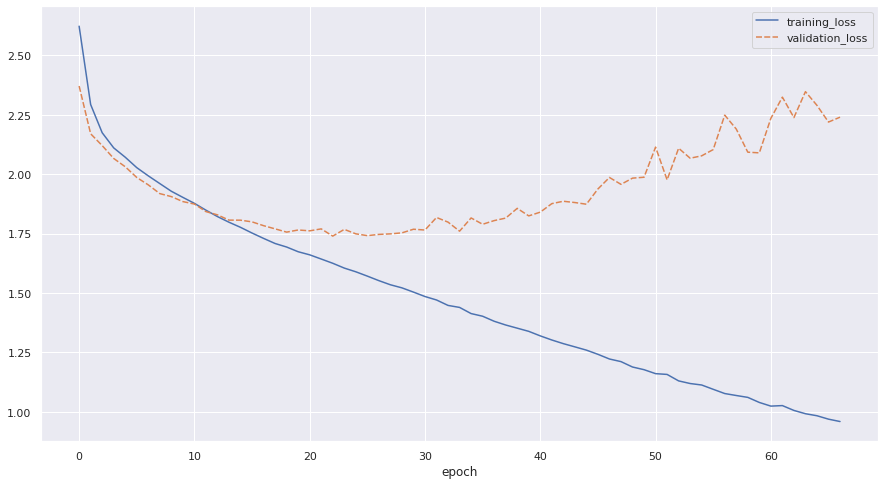

In [21]:
sns.lineplot(data=training_stats[['training_loss','validation_loss']])

<AxesSubplot:xlabel='epoch'>

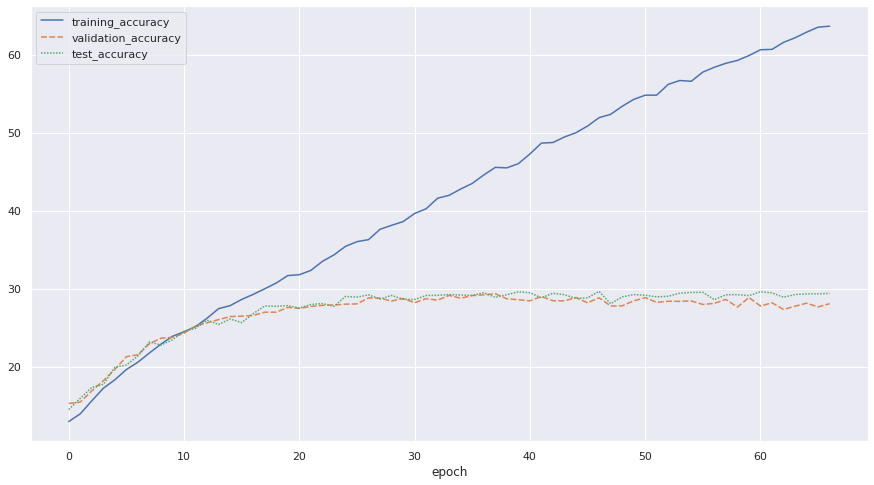

In [22]:
sns.lineplot(data=training_stats[['training_accuracy','validation_accuracy','test_accuracy']])

#### Checking Model performance on each configuration  

In [23]:
def validate():
    model.eval()
    val_loss = 0
    accuracy = 0
    epoch = 1
    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(validloader):
        counter += 1
#         print(counter)
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
        loss, acc = model.validate_(image, target, meta_target)
#         print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
#         print(counter)
    if counter >0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return  acc_all/float(counter)

def test():
    model.eval()
    accuracy = 0
    epoch = 1
    acc_all = 0.0
    counter = 0
    for batch_idx, (image, target, meta_target) in enumerate(testloader):
        counter += 1
        if args.cuda:
            image = image.cuda()
            target = target.cuda()
            meta_target = meta_target.cuda()
#             meta_structure = meta_structure.cuda()
#             embedding = embedding.cuda()
#             indicator = indicator.cuda()
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)

In [24]:
config_lst = []
config_val_acc_list = []
config_test_acc_list = []
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    validloader = DataLoader(valid_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    testloader = DataLoader(test_dt, batch_size=args.batch_size, shuffle=False, num_workers=16)
    config_lst.append(i[1:-1])
    config_val_acc_list.append(validate())
    config_test_acc_list.append(test())
    
    

Total Validation Loss: 1.870235, Acc: 39.7817
Total Testing Acc: 40.8234
Total Validation Loss: 2.578911, Acc: 25.2976
Total Testing Acc: 27.8274
Total Validation Loss: 2.374107, Acc: 24.4048
Total Testing Acc: 23.6607
Total Validation Loss: 2.298009, Acc: 21.1310
Total Testing Acc: 24.1567


In [26]:
pd.DataFrame({'configaration':config_lst,'validation_accuracy':config_val_acc_list, 'test_accuracy':config_test_acc_list})

,configaration,validation_accuracy,test_accuracy
0,center_single,39.781746,40.823413
1,distribute_four,25.297619,27.827381
2,in_distribute_four_out_center_single,24.404762,23.660714
3,left_center_single_right_center_single,21.130952,24.156746


In [27]:
for i in ['/center_single/','/distribute_four/','/in_distribute_four_out_center_single/', '/left_center_single_right_center_single/']:
    train_dt = dataset(data_path, "train", args.img_size, transform=transforms.Compose([ToTensor()]))
    valid_dt = dataset(data_path, "val", args.img_size, transform=transforms.Compose([ToTensor()]))
    test_dt = dataset(data_path, "test", args.img_size, transform=transforms.Compose([ToTensor()]))
    train_dt.file_names = [x for x in train_dt.file_names if i in x]
    valid_dt.file_names = [x for x in valid_dt.file_names if i in x]
    test_dt.file_names = [x for x in test_dt.file_names if i in x]
    print(i,len(set(train_dt.file_names)),len(set(valid_dt.file_names)),len(set(test_dt.file_names)))


/center_single/ 6000 2000 2000
/distribute_four/ 6000 2000 2000
/in_distribute_four_out_center_single/ 6000 2000 2000
/left_center_single_right_center_single/ 6000 2000 2000


In [28]:
training_stats.tail(1)

,training_loss,training_accuracy,validation_loss,validation_accuracy,test_accuracy
epoch,,,,,
66,0.958743,63.641667,2.239764,28.075,29.4


In [127]:
import numpy as np

In [178]:
a = np.load('/common/users/pv217/iraven_data_ext/distribute_four/RAVEN_100_train.npz')

In [179]:
for items in a:
    print(items)

target
predict
image
meta_matrix
meta_structure
meta_target
structure


In [187]:
# a["meta_matrix"]

In [181]:
a["target"]

array(7)

In [182]:
a["meta_structure"]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [183]:
a["meta_target"]

array([1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=uint8)

In [184]:
a["structure"]

array(['Scene', 'Singleton', 'Grid', 'Distribute_Four', '/', '/', '/',
       '/'], dtype='|S15')

In [185]:
import matplotlib.pyplot as plt

In [29]:
model

CNN_Logical(
  (conv): conv_module(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (batch_norm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU()
  )
  (softmax): Softmax(dim=1)
  (not_layer_1): Linear(in_features=256, out_features=256, bias=True)
  (not_layer_2): Linear(in_features=256, out_features=256, bias=True)
  (and_layer_1): Linear(in_features=512, out_features=256, bias=T